In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as st

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(recent)

('2017-08-23',)


Gathering data from 2016-08-23 onwards.


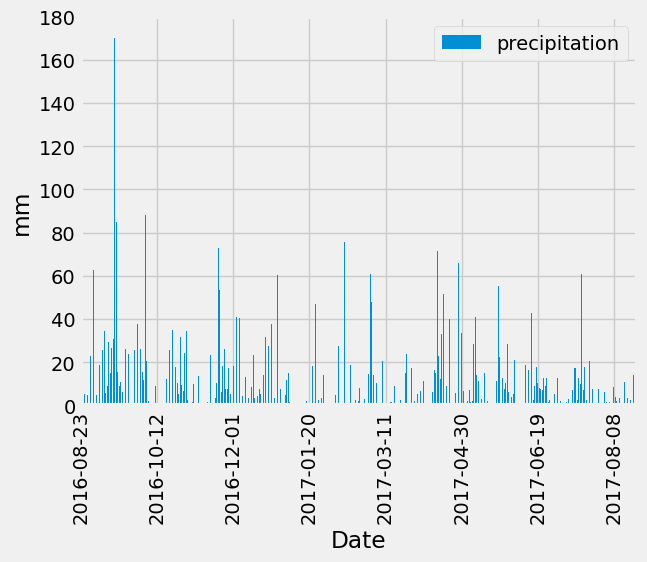

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent_date = dt.date(2017, 8, 23)
# Calculate the date one year from the last date in data set.
query_date = recent_date - dt.timedelta(days=365)
print("Gathering data from " + str(query_date) + " onwards.")

# Perform a query to retrieve the data and precipitation scores - taking only date and prcp
year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
year_prcp_df = pd.DataFrame(year_prcp).rename(columns={'date': 'date', 'prcp': 'precipitation'})

# Sort the dataframe by date
year_prcp_df = year_prcp_df.sort_values('date', ascending=True)
year_prcp_df = year_prcp_df.dropna()
year_prcp_df = year_prcp_df.groupby('date').max()
year_prcp_df

# Use Pandas Plotting with Matplotlib to plot the data
year_prcp_df.plot(kind='bar')
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 365, step=50))
plt.ylim(0, 180)
plt.ylabel('mm')
plt.xlabel('Date')
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = {"count": None, "mean": None, "std": None, "min": None, "25%": None, "50%": None, "75%": None, "max": None}

prcp_count = year_prcp_df.count()
summary['count'] = prcp_count

prcp_mean = year_prcp_df['precipitation'].mean()
summary['mean'] = prcp_mean

prcp_std = year_prcp_df['precipitation'].std()
summary['std'] = prcp_std

prcp_min = year_prcp_df['precipitation'].min()
summary['min'] = prcp_min

quartiles = year_prcp_df.quantile([.25, .5, .75])
summary['25%'] = quartiles.iloc[0, 0]
summary['50%'] = quartiles.iloc[1, 0]
summary['75%'] = quartiles.iloc[2, 0]

prcp_max = year_prcp_df['precipitation'].max()
summary['max'] = prcp_max

summary_df = pd.DataFrame(summary)
summary_df

,count,mean,std,min,25%,50%,75%,max
precipitation,366,13.231694,21.101073,0.0,1.0,6.4,17.1,170.2


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).count()
station_count

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
activity = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(func.min(Measurement.prcp), func.max(Measurement.prcp), func.avg(Measurement.prcp)).\
                    filter(Measurement.station == 'USC00519281').first()
most_active

(0.0, 244.9, 5.397619047619008)

array([[<Axes: title={'center': 'tobs'}>]], dtype=object)

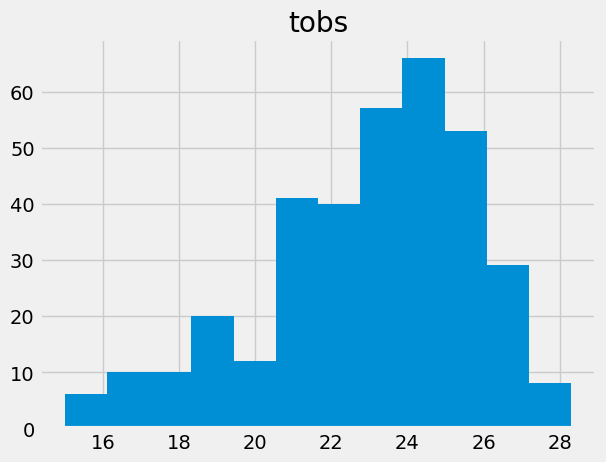

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_year_prcp = session.query(Measurement.tobs).\
                            filter(Measurement.station == 'USC00519281').filter(Measurement.date >= query_date).all()

most_active_year_prcp_df = pd.DataFrame(most_active_year_prcp)

most_active_year_prcp_df.hist(bins=12)


# Close Session

In [16]:
# Close Session
session.close()